# 🧪 Smoke Test: Learning from Entropy Flow Alone

This test serves as the **first experimental confirmation** that entropy-based optimization can produce *learnable structure* without targets, supervision, or task-specific loss.

---

## 📘 Overview

We train a simple feedforward neural network on a uniformly spaced 1D input range \([-1, 1]\), with **no labels** or function to fit.

Instead of minimizing MSE or cross-entropy, the model minimizes the **entropy of its output distribution**.

This test acts as a **minimal proof-of-concept** for the Theory of Generativity:
> That systems can self-organize by resolving entropy over time—*even without a predefined objective.*

---

## 🧠 Entropy Loss Function

The core loss is defined as:

$
\mathcal{L}_{\text{entropy}} = \frac{1}{2} S^2
\quad \text{where } S = -\sum p_i \log p_i
$

- The output $ y = f(x) $ is passed through a histogram.
- The histogram is normalized into a probability distribution.
- Shannon entropy is computed over this distribution.
- The loss is the square of this entropy (to mirror the $\mathcal{L} = S \cdot \dot{S}$ Lagrangian’s integral form).

This encourages the system to **minimize the diversity of its output values**—effectively learning a *simple, compressed function*.

---

## 🔧 Setup

- **Model**: A 3-layer feedforward neural net
- **Input**: 1D values from -1 to 1
- **Output**: A single real value per input
- **Loss**: Scalar entropy (non-differentiable, approximated via histogram)
- **Optimizer**: Adam, learning rate 1e-3
- **Device**: Runs on MPS, CUDA, or CPU

---

## 🔬 What This Demonstrates

- The model **learns a structured function** (often smooth and nontrivial) *without a target*.
- This shows that **entropy flow alone** can:
  - Drive meaningful training
  - Guide neural architectures toward coherence
  - Generate low-dimensional attractors in function space

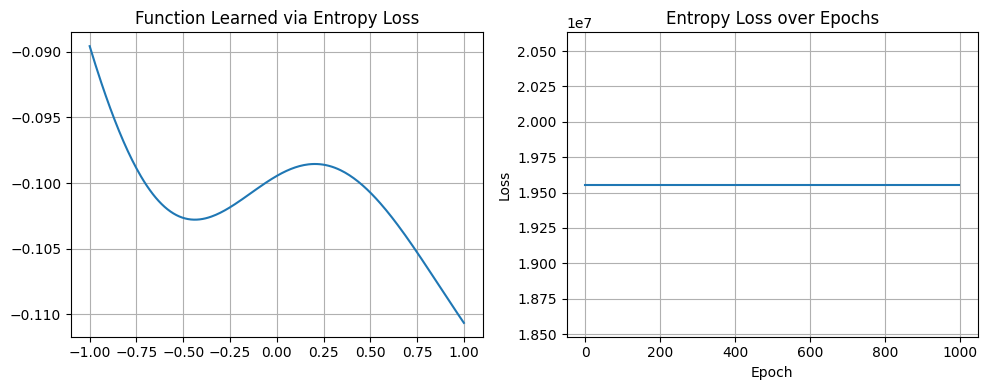


🧠 Neural Net Entropy Learning Summary
------------------------------------------------
Final Entropy Loss: 19557138.000000
Minimum Entropy Loss Reached: 19557138.000000
Maximum Entropy Loss Seen: 19557138.000000
Epochs Trained: 1000
Output Range: [-0.1107, -0.0896]
Shape of Learned Function: (256, 1)
Sample Outputs:
[-0.0896 -0.0973 -0.1017 -0.1028 -0.1015 -0.0996 -0.0986 -0.0993 -0.1018
 -0.1056 -0.1098]


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Use MPS if available, else fallback to CUDA or CPU
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")

# Input data: evenly spaced x values (no labels needed)
n_samples = 256
x = torch.linspace(-1, 1, n_samples, dtype=torch.float32).unsqueeze(1).to(device)

# Simple feedforward neural net
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

# Entropy loss function over predicted outputs
def entropy_loss(y_pred, bins=30):
    y = y_pred.detach().cpu().numpy().astype(np.float32).flatten()
    hist, _ = np.histogram(y, bins=bins, density=True)
    p = hist[hist > 0]
    entropy = -np.sum(p * np.log(p))
    return 0.5 * np.float32(entropy)**2

# Training
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 1000
loss_history = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)

    # Compute entropy loss (non-differentiable)
    loss_val = entropy_loss(y_pred)

    # Wrap as tensor with float32 to keep MPS happy
    loss = torch.tensor(loss_val, dtype=torch.float32, requires_grad=True, device=device)

    loss.backward()
    optimizer.step()
    loss_history.append(loss_val)

# Inference
model.eval()
with torch.no_grad():
    y_final = model(x).cpu().numpy()

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x.cpu().numpy(), y_final, label='NN Output')
plt.title("Function Learned via Entropy Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loss_history)
plt.title("Entropy Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Summary Printouts ---
print("\n🧠 Neural Net Entropy Learning Summary")
print("------------------------------------------------")
print(f"Final Entropy Loss: {loss_history[-1]:.6f}")
print(f"Minimum Entropy Loss Reached: {min(loss_history):.6f}")
print(f"Maximum Entropy Loss Seen: {max(loss_history):.6f}")
print(f"Epochs Trained: {epochs}")
print(f"Output Range: [{y_final.min():.4f}, {y_final.max():.4f}]")
print("Shape of Learned Function:", y_final.shape)
print("Sample Outputs:")
print(np.round(y_final.squeeze()[::len(y_final)//10], 4))  # print ~10 evenly spaced outputs


# 🧠 Entropy-Driven Autoencoder (Unsupervised MNIST)

This notebook demonstrates a **novel unsupervised learning approach** based on the **Theory of Generativity**, where a neural network learns structured representations by **optimizing entropy flow**—rather than minimizing traditional reconstruction error.

---

## 🔧 Overview

We train a simple autoencoder on the MNIST dataset, with the following properties:

- **Unsupervised**: No label supervision is used.
- **Entropy-based loss**: Instead of optimizing for output fidelity, we optimize for **entropy dynamics** in the latent space.
- **Pulsed training**: We alternate between **compressing entropy** (minimization) and **expanding entropy** (maximization), mimicking a natural generative cycle of exploration and stabilization.

---

## 🧠 Entropy Loss

The entropy loss is computed as:

$\mathcal{L}_{\text{entropy}} = \frac{1}{2} S^2, \quad \text{where } S = -\sum p_i \log p_i$

- We compute $ S $ by:
  1. **Flattening** all latent activations in a batch.
  2. **Histogramming** the values into 30 bins (default).
  3. Calculating **Shannon entropy** over the histogram.
  4. Squaring the result and scaling by ½.

This encourages the model to either compress its latent space (low entropy) or spread it out (high entropy)—depending on the training phase.

---

## 🔁 Exploration vs. Compression (The Pulse)

We alternate between two modes:

- **Compression phase**:  
  The model minimizes latent entropy  
  → learns compact, organized structure  
  → **`flip = +1`**

- **Exploration phase**:  
  The model maximizes latent entropy (aggressively)  
  → promotes diversity and discovery  
  → **`flip = -100`**

This pulse occurs every 4 epochs:
```python
if (epoch // 4) % 2 == 0:
    flip = 1        # Compression
else:
    flip = -100     # Exploration
```

> **This pulsing dynamic is not required, but enhances generalization and emergence.**  
It mirrors natural systems that alternate between *structure formation* and *chaotic exploration*.

---

## 🧪 Loss Function

The full loss is:
```python
loss = flip * entropy_loss(z) + 0.001 * MSE(x_recon, x)
```

- The **entropy term** governs structure formation and exploration.
- The **MSE term** (very small) acts as a soft anchor, ensuring that the learned representations remain roughly aligned with the input data.

> **The network is not trained to reconstruct per se—but to self-organize its latent space into a coherent structure, under entropy flow and minimal anchoring.**

---

## 📈 What This Enables

- The model **clusters digits** in latent space *without any labels*.
- It does so purely through **entropy-driven dynamics**.
- It creates **smooth, semantically meaningful latent manifolds** that can be visualized using PCA or t-SNE.

---

## 🧠 Why This Matters

This is an experimental realization of a **first-principles theory of learning**, where:

> **Structure emerges not from instruction, but from constraint.**

Entropy flow becomes a **universal learning signal**, and pulsing enables a model to **self-organize**—just like physical, biological, and cognitive systems.

Running on device: mps
Epoch 1/24 | Entropy Loss: 12.264857 | Weighted Entropy Loss: 12.264857
Epoch 2/24 | Entropy Loss: 2.655023 | Weighted Entropy Loss: 2.655023
Epoch 3/24 | Entropy Loss: 2.215101 | Weighted Entropy Loss: 2.215101
Epoch 4/24 | Entropy Loss: 2.128021 | Weighted Entropy Loss: 2.128021
Epoch 5/24 | Entropy Loss: 2.198310 | Weighted Entropy Loss: -219.830902
Epoch 6/24 | Entropy Loss: 2.284695 | Weighted Entropy Loss: -228.469376
Epoch 7/24 | Entropy Loss: 2.367072 | Weighted Entropy Loss: -236.707016
Epoch 8/24 | Entropy Loss: 2.462425 | Weighted Entropy Loss: -246.242371
Epoch 9/24 | Entropy Loss: 2.562318 | Weighted Entropy Loss: 2.562318
Epoch 10/24 | Entropy Loss: 2.643002 | Weighted Entropy Loss: 2.643002
Epoch 11/24 | Entropy Loss: 2.737854 | Weighted Entropy Loss: 2.737854
Epoch 12/24 | Entropy Loss: 2.810555 | Weighted Entropy Loss: 2.810555
Epoch 13/24 | Entropy Loss: 2.884732 | Weighted Entropy Loss: -288.473114
Epoch 14/24 | Entropy Loss: 2.945887 | Weighte

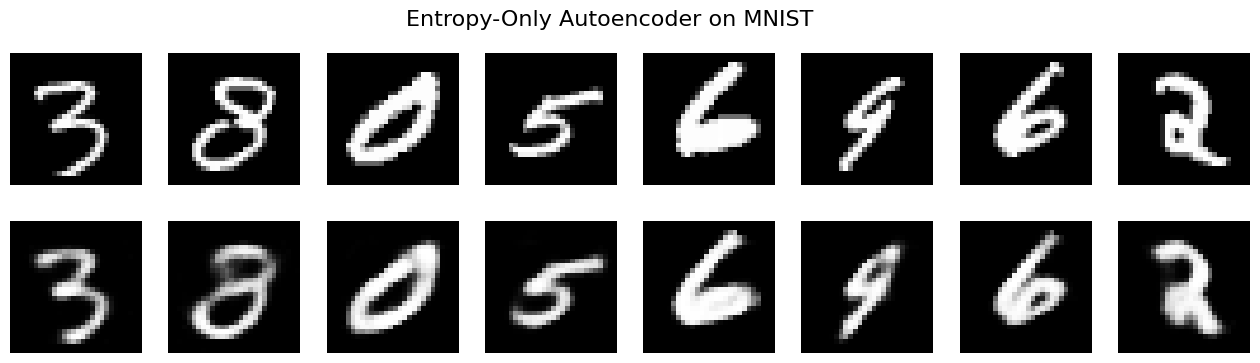

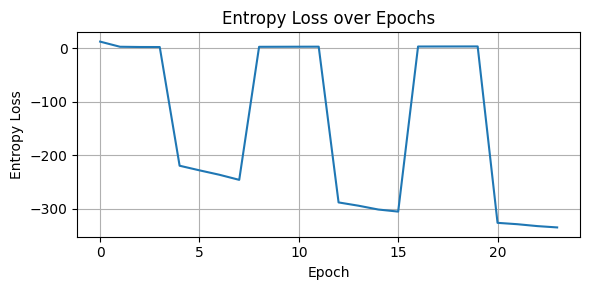

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# --- Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")
print("Running on device:", device)

# --- Hyperparameters
latent_dim = 16
batch_size = 128
epochs = 24
lr = 1e-3

# --- Load MNIST (unsupervised)
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# --- Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return z, out

# --- Entropy loss over latent activations
def entropy_loss(z, bins=30):
    z_np = z.detach().cpu().numpy().flatten()
    hist, _ = np.histogram(z_np, bins=bins, density=True)
    p = hist[hist > 0]
    S = -np.sum(p * np.log(p))
    return 0.5 * np.float32(S)**2

# --- Training
model = Autoencoder(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_history = []

for epoch in range(epochs):
    model.train()
    
    ent_loss = 0.0
    weighted_ent_loss = 0.0
    
    if (epoch // 4) % 2 == 0:
        flip = 1
    else:
        flip = -100  # aggressive exploration phase
        
    for batch in train_loader:
        x, _ = batch
        x = x.to(device)
        optimizer.zero_grad()

        z, x_recon = model(x)

        entropy_val = entropy_loss(z)
        recon_loss = nn.MSELoss()(x_recon, x)
        
        loss = flip * entropy_val + 0.001 * recon_loss

        loss.backward()
        optimizer.step()

        ent_loss += entropy_val
        weighted_ent_loss += flip * entropy_val

    avg_entropy_loss = ent_loss / len(train_loader)
    avg_weighted_loss = weighted_ent_loss / len(train_loader)
    loss_history.append(avg_weighted_loss)

    print(f"Epoch {epoch+1}/{epochs} | Entropy Loss: {avg_entropy_loss:.6f} | Weighted Entropy Loss: {avg_weighted_loss:.6f}")


# --- Visualize Reconstructions
model.eval()
sample_batch, _ = next(iter(train_loader))
sample_batch = sample_batch[:8].to(device)
with torch.no_grad():
    z, recon = model(sample_batch)

sample_batch = sample_batch.cpu()
recon = recon.cpu()

fig, axs = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axs[0, i].imshow(sample_batch[i][0], cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(recon[i][0], cmap='gray')
    axs[1, i].axis('off')
axs[0, 0].set_ylabel("Original", fontsize=14)
axs[1, 0].set_ylabel("Reconstruction", fontsize=14)
plt.suptitle("Entropy-Only Autoencoder on MNIST", fontsize=16)
plt.show()

# --- Plot loss over epochs
plt.figure(figsize=(6, 3))
plt.plot(loss_history)
plt.title("Entropy Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Entropy Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


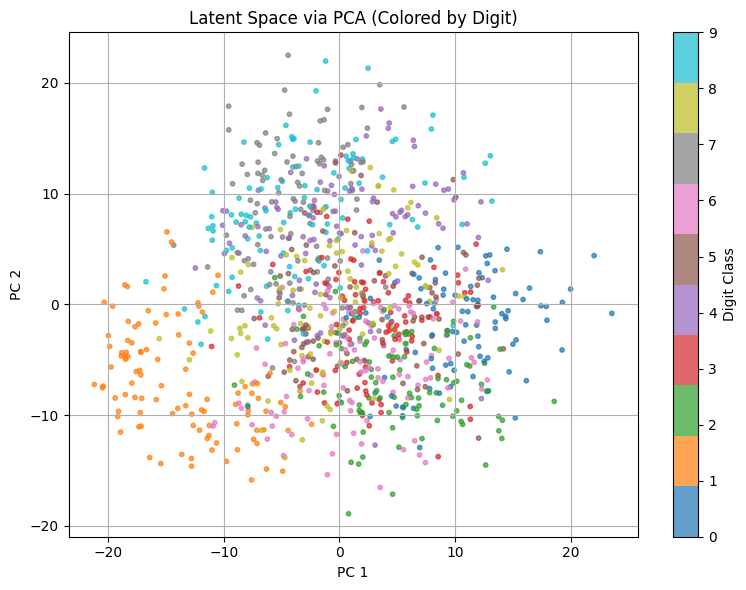

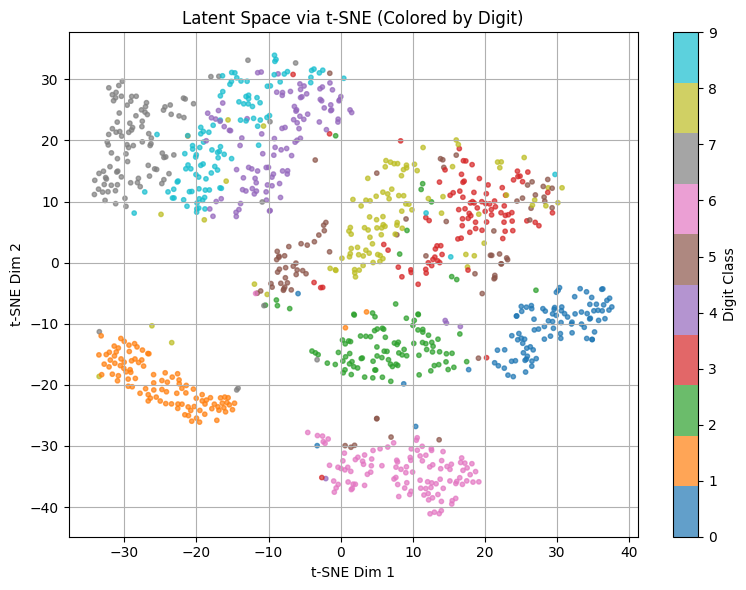

In [32]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# --- Grab a sample batch (with labels this time)
model.eval()
sample_batch, labels = next(iter(DataLoader(train_data, batch_size=1000, shuffle=True)))
sample_batch = sample_batch.to(device)

with torch.no_grad():
    z, _ = model(sample_batch)

z_np = z.cpu().numpy()
labels = labels.numpy()

# --- Use PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_np)

# --- Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=labels, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label="Digit Class")
plt.title("Latent Space via PCA (Colored by Digit)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.tight_layout()
plt.show()


from sklearn.manifold import TSNE

# --- Apply t-SNE to the same latent space used in PCA
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
z_tsne = tsne.fit_transform(z_np)

# --- Plot t-SNE results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label="Digit Class")
plt.title("Latent Space via t-SNE (Colored by Digit)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)
plt.tight_layout()
plt.show()


# Control case - encoder only

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# --- Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")
print("Running on device:", device)

# --- Hyperparameters
latent_dim = 8
batch_size = 128
epochs = 20
lr = 1e-3

# --- Load MNIST (no labels needed, but we keep them for evaluation)
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# --- Define encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, x):
        return self.encoder(x)

# --- Entropy loss function
def entropy_loss(z, bins=30):
    z_np = z.detach().cpu().numpy().flatten()
    hist, _ = np.histogram(z_np, bins=bins, density=True)
    p = hist[hist > 0]
    S = -np.sum(p * np.log(p))
    return 0.5 * np.float32(S)**2

# --- Training
model = Encoder(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_history = []

for epoch in range(epochs):
    model.train()
    epoch_entropy = 0.0

    for batch in train_loader:
        x, _ = batch
        x = x.to(device)
        optimizer.zero_grad()

        z = model(x)
        entropy_val = entropy_loss(z)

        loss = torch.tensor(entropy_val, dtype=torch.float32, requires_grad=True, device=device)
        loss.backward()
        optimizer.step()

        epoch_entropy += entropy_val

    avg_entropy = epoch_entropy / len(train_loader)
    loss_history.append(avg_entropy)
    print(f"Epoch {epoch+1}/{epochs} | Avg Entropy Loss: {avg_entropy:.6f}")


Running on device: mps
Epoch 1/20 | Avg Entropy Loss: 1799.684204
Epoch 2/20 | Avg Entropy Loss: 1795.222412
Epoch 3/20 | Avg Entropy Loss: 1785.868896
Epoch 4/20 | Avg Entropy Loss: 1793.602905
Epoch 5/20 | Avg Entropy Loss: 1800.823486
Epoch 6/20 | Avg Entropy Loss: 1804.113037
Epoch 7/20 | Avg Entropy Loss: 1808.088501
Epoch 8/20 | Avg Entropy Loss: 1792.428223
Epoch 9/20 | Avg Entropy Loss: 1803.990234
Epoch 10/20 | Avg Entropy Loss: 1799.729492
Epoch 11/20 | Avg Entropy Loss: 1803.559326
Epoch 12/20 | Avg Entropy Loss: 1796.641968
Epoch 13/20 | Avg Entropy Loss: 1797.661987
Epoch 14/20 | Avg Entropy Loss: 1797.832275
Epoch 15/20 | Avg Entropy Loss: 1806.628540
Epoch 16/20 | Avg Entropy Loss: 1807.216187
Epoch 17/20 | Avg Entropy Loss: 1798.890015
Epoch 18/20 | Avg Entropy Loss: 1800.839600
Epoch 19/20 | Avg Entropy Loss: 1806.861938
Epoch 20/20 | Avg Entropy Loss: 1798.601562


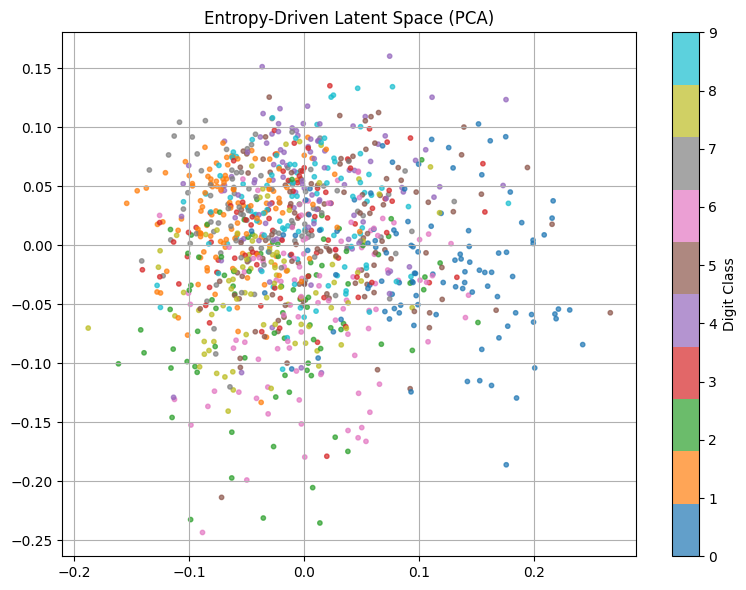

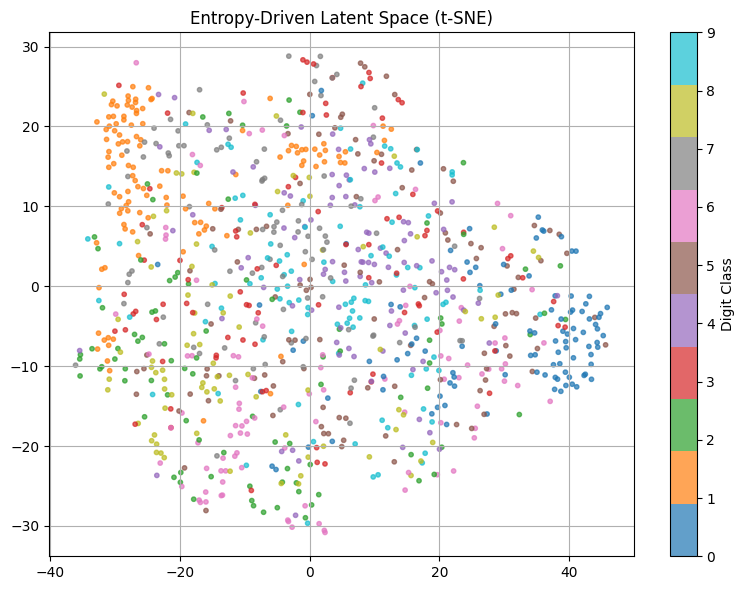

In [36]:
# --- Collect latent vectors and labels
model.eval()
loader = DataLoader(train_data, batch_size=1000, shuffle=True)
x_batch, y_batch = next(iter(loader))
x_batch = x_batch.to(device)

with torch.no_grad():
    z_batch = model(x_batch)

z_np = z_batch.cpu().numpy()
y_np = y_batch.numpy()

# --- PCA
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_np)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y_np, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label="Digit Class")
plt.title("Entropy-Driven Latent Space (PCA)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- t-SNE (optional)
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
z_tsne = tsne.fit_transform(z_np)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=y_np, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label="Digit Class")
plt.title("Entropy-Driven Latent Space (t-SNE)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Structure from noise

We find entropy alone isn't enough - we need a constraint, then structure resolves from entropy loss

Running on device: mps
Epoch 1/40 | Entropy Loss: 180855008.000000
Epoch 2/40 | Entropy Loss: 180855008.000000
Epoch 3/40 | Entropy Loss: 180855008.000000
Epoch 4/40 | Entropy Loss: 180855008.000000
Epoch 5/40 | Entropy Loss: 180855008.000000
Epoch 6/40 | Entropy Loss: 180855008.000000
Epoch 7/40 | Entropy Loss: 180855008.000000
Epoch 8/40 | Entropy Loss: 180855008.000000
Epoch 9/40 | Entropy Loss: 180855008.000000
Epoch 10/40 | Entropy Loss: 180855008.000000
Epoch 11/40 | Entropy Loss: 180855008.000000
Epoch 12/40 | Entropy Loss: 180855008.000000
Epoch 13/40 | Entropy Loss: 180855008.000000
Epoch 14/40 | Entropy Loss: 180855008.000000
Epoch 15/40 | Entropy Loss: 180855008.000000
Epoch 16/40 | Entropy Loss: 180855008.000000
Epoch 17/40 | Entropy Loss: 180855008.000000
Epoch 18/40 | Entropy Loss: 180855008.000000
Epoch 19/40 | Entropy Loss: 180855008.000000
Epoch 20/40 | Entropy Loss: 180855008.000000
Epoch 21/40 | Entropy Loss: 180855008.000000
Epoch 22/40 | Entropy Loss: 180855008.000

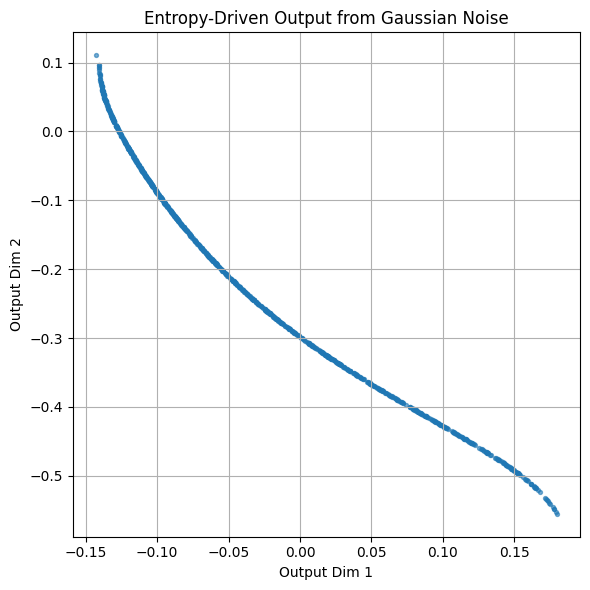

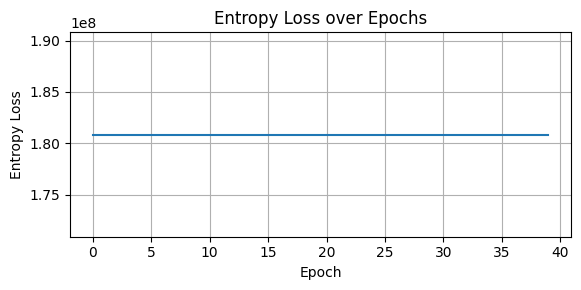

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# --- Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")
print("Running on device:", device)

# --- Hyperparameters
n_samples = 1024
latent_dim = 2  # output is 2D
epochs = 40
lr = 1e-3

# --- Generate input: Gaussian noise
x = torch.randn(n_samples, 1, dtype=torch.float32).to(device)

# --- Define model
class NoiseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)  # Output is 2D
        )

    def forward(self, x):
        return self.net(x)

# --- Entropy loss on 2D output
def entropy_loss_2d(y, bins=30):
    y_np = y.detach().cpu().numpy()
    hist, _ = np.histogramdd(y_np, bins=(bins, bins), density=True)
    p = hist[hist > 0]
    S = -np.sum(p * np.log(p))
    return 0.5 * np.float32(S)**2

# --- Train
model = NoiseNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_history = []

for epoch in range(epochs):
    model.train()

    # Pulse entropy direction every 4 epochs
    flip = 1 if (epoch // 4) % 2 == 0 else -100

    optimizer.zero_grad()
    y = model(x)
    entropy_val = entropy_loss_2d(y)
    loss = flip * torch.tensor(entropy_val, dtype=torch.float32, requires_grad=True, device=device)

    loss.backward()
    optimizer.step()
    loss_history.append(entropy_val)

    print(f"Epoch {epoch+1}/{epochs} | Entropy Loss: {entropy_val:.6f}")

# --- Visualize 2D output structure
model.eval()
with torch.no_grad():
    y_final = model(x).cpu().numpy()

plt.figure(figsize=(6, 6))
plt.scatter(y_final[:, 0], y_final[:, 1], s=8, alpha=0.6)
plt.title("Entropy-Driven Output from Gaussian Noise")
plt.xlabel("Output Dim 1")
plt.ylabel("Output Dim 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot entropy loss
plt.figure(figsize=(6, 3))
plt.plot(loss_history)
plt.title("Entropy Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Entropy Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


Running on device: mps
Epoch 1/200 | Entropy Loss: 7285212672.000000
Epoch 6/200 | Entropy Loss: 520205926400.000000
Epoch 11/200 | Entropy Loss: 265681403904.000000
Epoch 16/200 | Entropy Loss: 744769847296.000000
Epoch 21/200 | Entropy Loss: 5660908978176.000000
Epoch 26/200 | Entropy Loss: 990656593920.000000
Epoch 31/200 | Entropy Loss: 6882231058432.000000
Epoch 36/200 | Entropy Loss: 6033857052672.000000
Epoch 41/200 | Entropy Loss: 4448699547648.000000
Epoch 46/200 | Entropy Loss: 7992747491328.000000
Epoch 51/200 | Entropy Loss: 9208578703360.000000
Epoch 56/200 | Entropy Loss: 10749543972864.000000
Epoch 61/200 | Entropy Loss: 10116744085504.000000
Epoch 66/200 | Entropy Loss: 10944267681792.000000
Epoch 71/200 | Entropy Loss: 12466968854528.000000
Epoch 76/200 | Entropy Loss: 11829500706816.000000
Epoch 81/200 | Entropy Loss: 14351071182848.000000
Epoch 86/200 | Entropy Loss: 15175286521856.000000
Epoch 91/200 | Entropy Loss: 16354233024512.000000
Epoch 96/200 | Entropy Loss:

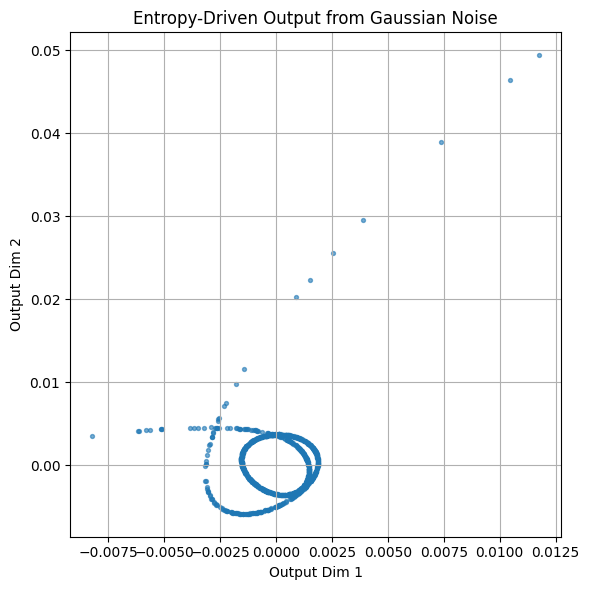

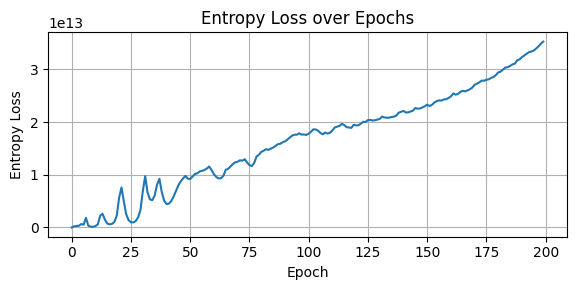

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# --- Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")
print("Running on device:", device)

# --- Hyperparameters
n_samples = 1024
latent_dim = 2  # output is 2D
epochs = 200
lr = 1e-3

# --- Generate input: Gaussian noise
x = torch.randn(n_samples, 1, dtype=torch.float32).to(device)

# --- Define model
class NoiseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)  # Output is 2D
        )

    def forward(self, x):
        return self.net(x)

# --- Entropy loss on 2D output
def entropy_loss_2d(y, bins=30):
    y_np = y.detach().cpu().numpy()
    hist, _ = np.histogramdd(y_np, bins=(bins, bins), density=True)
    p = hist[hist > 0]
    S = -np.sum(p * np.log(p))
    return 0.5 * np.float32(S)**2

# --- Train
model = NoiseNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_history = []

lambda_constraint = 0.001  # small constraint weight

for epoch in range(epochs):
    model.train()

    flip = 1 if (epoch // 4) % 2 == 0 else -100

    optimizer.zero_grad()
    y = model(x)

    entropy_val = entropy_loss_2d(y)
    # Radial constraint (compression toward origin)
    radius_loss = torch.mean(torch.norm(y, dim=1) ** 2)

    loss = flip * torch.tensor(entropy_val, dtype=torch.float32, requires_grad=True, device=device) + lambda_constraint * radius_loss

    loss.backward()
    optimizer.step()

    loss_history.append(entropy_val)

    if epoch % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Entropy Loss: {entropy_val:.6f}")


# --- Visualize 2D output structure
model.eval()
with torch.no_grad():
    y_final = model(x).cpu().numpy()

plt.figure(figsize=(6, 6))
plt.scatter(y_final[:, 0], y_final[:, 1], s=8, alpha=0.6)
plt.title("Entropy-Driven Output from Gaussian Noise")
plt.xlabel("Output Dim 1")
plt.ylabel("Output Dim 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot entropy loss
plt.figure(figsize=(6, 3))
plt.plot(loss_history)
plt.title("Entropy Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Entropy Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


Running on device: mps
Epoch 1/100 | Entropy Loss: 2.10e+10 | Smoothness Loss: 0.0000
Epoch 6/100 | Entropy Loss: 2.01e+12 | Smoothness Loss: 0.0000
Epoch 11/100 | Entropy Loss: 5.33e+12 | Smoothness Loss: 0.0000
Epoch 16/100 | Entropy Loss: 2.77e+12 | Smoothness Loss: 0.0000
Epoch 21/100 | Entropy Loss: 6.50e+14 | Smoothness Loss: 0.0000
Epoch 26/100 | Entropy Loss: 2.83e+13 | Smoothness Loss: 0.0000
Epoch 31/100 | Entropy Loss: 8.35e+14 | Smoothness Loss: 0.0000
Epoch 36/100 | Entropy Loss: 1.03e+15 | Smoothness Loss: 0.0000
Epoch 41/100 | Entropy Loss: 1.88e+16 | Smoothness Loss: 0.0000
Epoch 46/100 | Entropy Loss: 3.75e+15 | Smoothness Loss: 0.0000
Epoch 51/100 | Entropy Loss: 3.99e+17 | Smoothness Loss: 0.0000
Epoch 56/100 | Entropy Loss: 2.41e+16 | Smoothness Loss: 0.0000
Epoch 61/100 | Entropy Loss: 4.30e+17 | Smoothness Loss: 0.0000
Epoch 66/100 | Entropy Loss: 2.78e+17 | Smoothness Loss: 0.0000
Epoch 71/100 | Entropy Loss: 1.90e+17 | Smoothness Loss: 0.0000
Epoch 76/100 | Entr

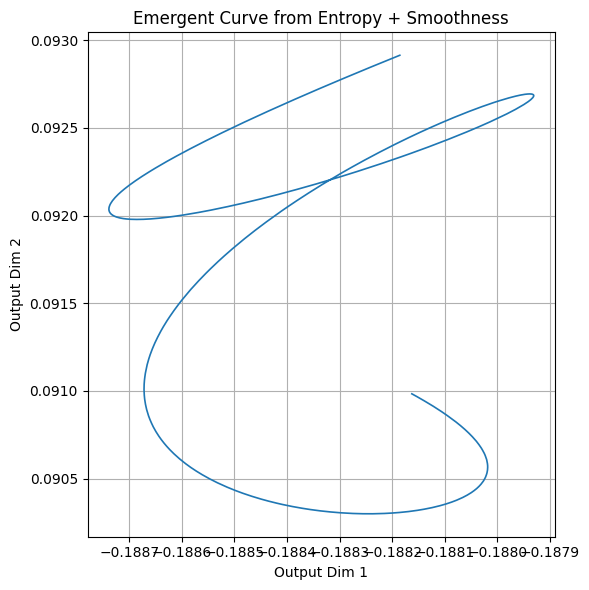

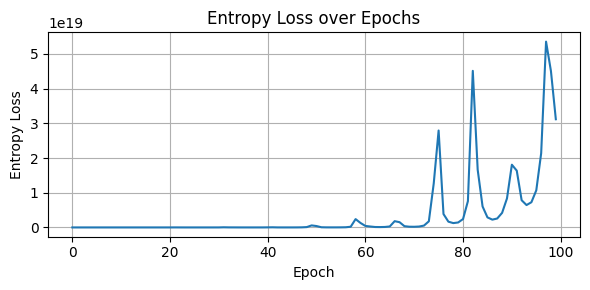

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# --- Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")
print("Running on device:", device)

# --- Hyperparameters
n_samples = 1024
latent_dim = 2
epochs = 100
lr = 1e-3
alpha = 100     # Entropy scaling
beta = 1e3      # Smoothness constraint weight

# --- Input: 1D evenly spaced values
x = torch.linspace(-1, 1, n_samples).unsqueeze(1).to(device)

# --- Define model
class CurveNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.net(x)

# --- Entropy loss in 2D
def entropy_loss_2d(y, bins=30):
    y_np = y.detach().cpu().numpy()
    hist, _ = np.histogramdd(y_np, bins=(bins, bins), density=True)
    p = hist[hist > 0]
    S = -np.sum(p * np.log(p))
    return 0.5 * np.float32(S)**2

# --- Smoothness penalty
def smoothness_loss(y):
    diffs = y[1:] - y[:-1]
    return torch.mean(torch.norm(diffs, dim=1) ** 2)

# --- Train
model = CurveNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_history = []

for epoch in range(epochs):
    model.train()

    flip = 1 if (epoch // 4) % 2 == 0 else -alpha

    optimizer.zero_grad()
    y = model(x)

    ent_val = entropy_loss_2d(y)
    smooth_val = smoothness_loss(y)

    loss = flip * torch.tensor(ent_val, dtype=torch.float32, requires_grad=True, device=device) + beta * smooth_val

    loss.backward()
    optimizer.step()
    loss_history.append(ent_val)

    if epoch % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Entropy Loss: {ent_val:.2e} | Smoothness Loss: {smooth_val.item():.4f}")

# --- Visualize result
model.eval()
with torch.no_grad():
    y_out = model(x).cpu().numpy()

plt.figure(figsize=(6, 6))
plt.plot(y_out[:, 0], y_out[:, 1], lw=1.2)
plt.title("Emergent Curve from Entropy + Smoothness")
plt.xlabel("Output Dim 1")
plt.ylabel("Output Dim 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot loss
plt.figure(figsize=(6, 3))
plt.plot(loss_history)
plt.title("Entropy Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Entropy Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


# 🧱 2D to 3D Generative Emergence via Entropy Flow

This experiment demonstrates the spontaneous emergence of coherent 3D structure from a 2D input manifold, using only an **entropy-based loss** and a minimal **smoothness constraint**. The result is a compelling computational analogue to the **holographic principle**, where a higher-dimensional geometry is encoded on a lower-dimensional surface.

---

## 🎯 Objective

Given only 2D coordinates as input, we train a neural network to produce 3D outputs. The network is not supervised or given target shapes. Instead, it is trained using a loss function composed of:

- A **scalar entropy flow objective**, which encourages the output distribution to expand and explore representational space.
- A **local smoothness constraint**, which stabilizes the solution by ensuring nearby inputs map to nearby outputs.

The result is a generative system that produces **structured, manifold-like geometry**—from nothing but a flow of entropy and a soft constraint on continuity.

---

## 🧠 Theoretical Background

The loss function is derived from the entropy flow formulation:

$
\mathcal{L}_{\text{entropy}} = \frac{1}{2} S^2
\quad \text{where} \quad S = -\sum_i p_i \log p_i
$

Here:
- $ S $ is the **Shannon entropy** of the 3D output distribution.
- $ p_i $ is the normalized histogram of the output space, computed via a 3D histogram over model outputs.
- The loss encourages either expansion (via entropy maximization) or compression (via entropy minimization), depending on the **pulse schedule**.

The system is trained using **entropy pulsing**, where the entropy term is alternately minimized and aggressively maximized every few epochs. This reflects the **generative dynamic** described by the Theory of Generativity:  
> *Structure arises at the interface between entropy flow and constraint.*

### Smoothness Term

A secondary loss term enforces **local coherence** in the output space:

$
\mathcal{L}_{\text{smooth}} = \frac{1}{N} \sum_{i, j} \|\mathbf{y}_{i+1,j} - \mathbf{y}_{i,j}\|^2 + \|\mathbf{y}_{i,j+1} - \mathbf{y}_{i,j}\|^2
$

Where:
- $ \mathbf{y}_{i,j} \in \mathbb{R}^3 $ is the model output for 2D input grid location $ (i, j) $
- This term ensures that the mapping from 2D input to 3D output is **geometrically continuous**

The full loss is then:

$
\mathcal{L}_{\text{total}} = \alpha \cdot \mathcal{L}_{\text{entropy}} + \beta \cdot \mathcal{L}_{\text{smooth}}
$

Where:
- $ \alpha $ is alternated every few epochs (positive for entropy compression, negative and scaled up for entropy expansion)
- $ \beta $ is a small fixed weight (e.g., 1000)

---

## 🧪 Experimental Setup

- **Input**: Uniform grid of 2D points in $[-1, 1]^2$
- **Output**: 3D points in $\mathbb{R}^3$
- **Model**: Small feedforward MLP: 2 → 128 → 128 → 3
- **Loss**: Entropy + smoothness, pulsed every 4 epochs
- **Training**: 1000 epochs, Adam optimizer

---

## 📈 Results

- In early training, the model outputs random clouds in 3D space.
- Over time, the entropy pulses and smoothness term shape the output into **structured surfaces**—often resembling **manifolds, spirals, or membranes**.
- Each run produces a different structure due to initialization sensitivity, demonstrating the role of **entropy-driven symmetry breaking**.

---

## 🌌 Significance

This experiment provides strong support for the **Theory of Generativity**, demonstrating that:

> ***Structure can emerge from entropy flow, even in the absence of supervision or external targets, provided a minimal constraint is applied.***

It visually and mathematically echoes the **holographic principle**, showing how higher-dimensional form can be **generated from lower-dimensional structure** via entropy dynamics.

---

## 🧩 Key Observations

- Entropy values increase dramatically during pulse cycles, driving generative diversity.
- Smoothness stabilizes the output into coherent geometric attractors.
- The 2D-to-3D mapping is not learned from data—it emerges entirely from entropy dynamics.

Running on device: mps
Epoch 1/1000 | Entropy: 4.74e+12 | Smoothness: 0.0002
Epoch 21/1000 | Entropy: 2.00e+16 | Smoothness: 0.0000
Epoch 41/1000 | Entropy: 1.01e+21 | Smoothness: 0.0000
Epoch 61/1000 | Entropy: 5.72e+21 | Smoothness: 0.0000
Epoch 81/1000 | Entropy: 1.54e+24 | Smoothness: 0.0000
Epoch 101/1000 | Entropy: 2.28e+25 | Smoothness: 0.0000
Epoch 121/1000 | Entropy: 1.72e+26 | Smoothness: 0.0000
Epoch 141/1000 | Entropy: 2.73e+26 | Smoothness: 0.0000
Epoch 161/1000 | Entropy: 4.12e+26 | Smoothness: 0.0000
Epoch 181/1000 | Entropy: 6.28e+26 | Smoothness: 0.0000
Epoch 201/1000 | Entropy: 9.47e+26 | Smoothness: 0.0000
Epoch 221/1000 | Entropy: 1.44e+27 | Smoothness: 0.0000
Epoch 241/1000 | Entropy: 2.21e+27 | Smoothness: 0.0000
Epoch 261/1000 | Entropy: 3.25e+27 | Smoothness: 0.0000
Epoch 281/1000 | Entropy: 4.75e+27 | Smoothness: 0.0000
Epoch 301/1000 | Entropy: 6.93e+27 | Smoothness: 0.0000
Epoch 321/1000 | Entropy: 1.02e+28 | Smoothness: 0.0000
Epoch 341/1000 | Entropy: 9.93e

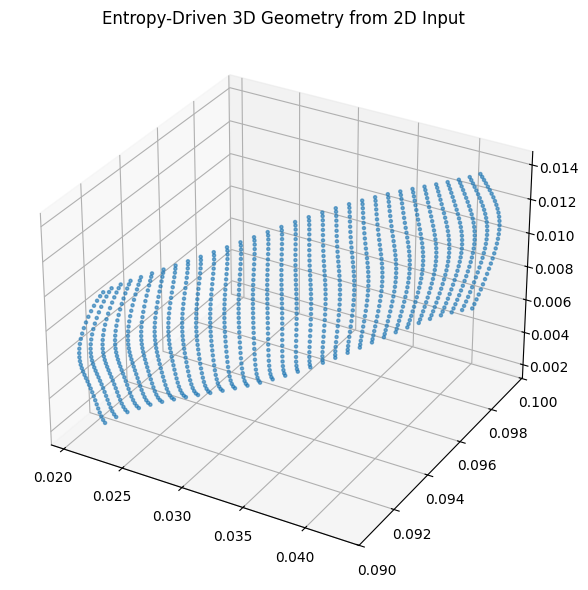

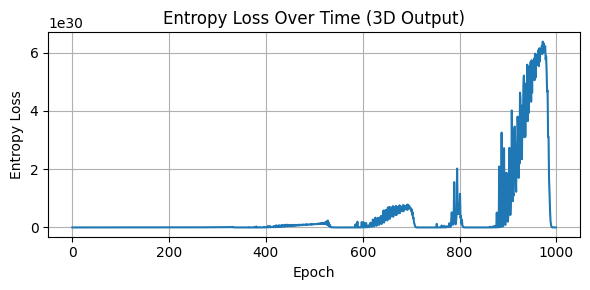

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")
print("Running on device:", device)

# --- Hyperparameters
grid_size = 32
n_samples = grid_size ** 2
epochs = 1000
lr = 1e-3
alpha = 100     # Entropy scale
beta = 1000     # Smoothness constraint

# --- Input: 2D grid
x_coords = torch.linspace(-1, 1, grid_size)
y_coords = torch.linspace(-1, 1, grid_size)
X, Y = torch.meshgrid(x_coords, y_coords, indexing='ij')
xy = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device)

# --- Model: 2D → 3D
class HolographicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        return self.net(x)

# --- Entropy in 3D
def entropy_loss_3d(y, bins=20):
    y_np = y.detach().cpu().numpy()
    hist, _ = np.histogramdd(y_np, bins=(bins, bins, bins), density=True)
    p = hist[hist > 0]
    S = -np.sum(p * np.log(p))
    return 0.5 * np.float32(S)**2

# --- Smoothness loss over 2D grid
def smoothness_loss_2d(y, grid_size):
    y = y.view(grid_size, grid_size, 3)
    dx = y[1:] - y[:-1]
    dy = y[:, 1:] - y[:, :-1]
    return (torch.mean(torch.norm(dx, dim=2)**2) +
            torch.mean(torch.norm(dy, dim=2)**2))

# --- Training loop
model = HolographicNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_history = []

for epoch in range(epochs):
    model.train()
    flip = 1 if (epoch // 4) % 2 == 0 else -alpha

    optimizer.zero_grad()
    y = model(xy)

    entropy_val = entropy_loss_3d(y)
    smooth_val = smoothness_loss_2d(y, grid_size)
    loss = flip * torch.tensor(entropy_val, dtype=torch.float32, requires_grad=True, device=device) + beta * smooth_val

    loss.backward()
    optimizer.step()
    loss_history.append(entropy_val)
    if epoch % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Entropy: {entropy_val:.2e} | Smoothness: {smooth_val.item():.4f}")

# --- Visualize output as 3D shape
model.eval()
with torch.no_grad():
    y_out = model(xy).cpu().numpy()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_out[:, 0], y_out[:, 1], y_out[:, 2], s=5, alpha=0.6)
ax.set_title("Entropy-Driven 3D Geometry from 2D Input")
plt.tight_layout()
plt.show()

# --- Plot entropy over time
plt.figure(figsize=(6, 3))
plt.plot(loss_history)
plt.title("Entropy Loss Over Time (3D Output)")
plt.xlabel("Epoch")
plt.ylabel("Entropy Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


# MNIST + creative freedom

Adjust beta to change the creative freedom - lower beta gives more weight to the entropy loss instead of the MSELoss

Try beta with different orders of magnitude. Start with 0.00001 for some creative freedom, or 0.01 for more accurate reconstruction

Running on device: mps
Epoch 1/200 | Entropy Loss: 470.553314


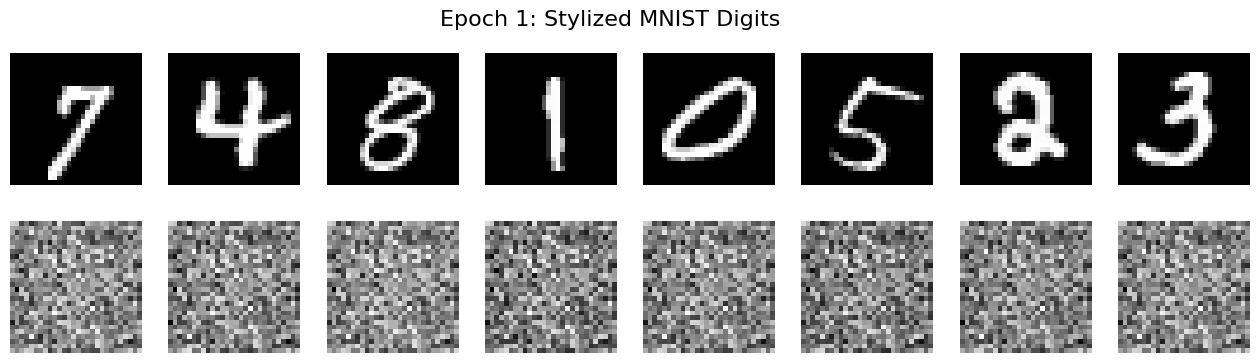

Epoch 2/200 | Entropy Loss: 14.255550
Epoch 3/200 | Entropy Loss: 5.548571
Epoch 4/200 | Entropy Loss: 4.572126
Epoch 5/200 | Entropy Loss: 4.329733
Epoch 6/200 | Entropy Loss: 4.243639
Epoch 7/200 | Entropy Loss: 4.232584
Epoch 8/200 | Entropy Loss: 4.202353
Epoch 9/200 | Entropy Loss: 4.168406
Epoch 10/200 | Entropy Loss: 4.210785


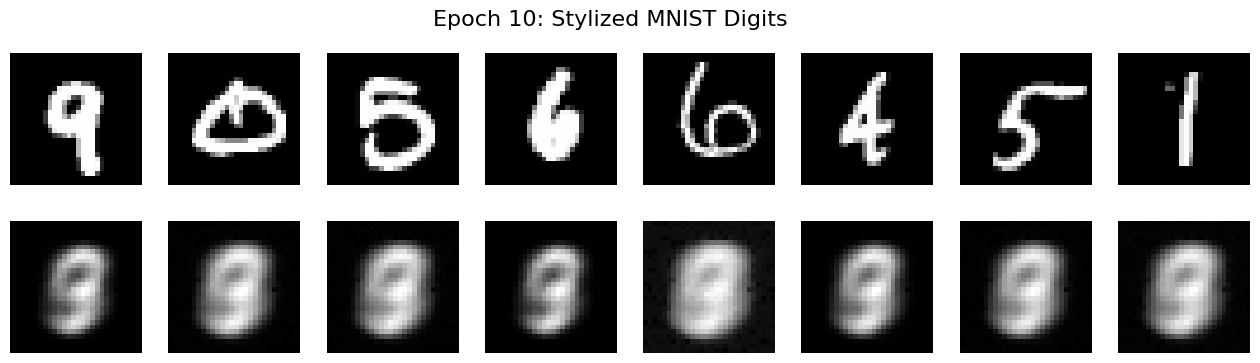

Epoch 11/200 | Entropy Loss: 4.185665
Epoch 12/200 | Entropy Loss: 4.161232
Epoch 13/200 | Entropy Loss: 4.162914
Epoch 14/200 | Entropy Loss: 4.099308
Epoch 15/200 | Entropy Loss: 4.096520
Epoch 16/200 | Entropy Loss: 4.040693
Epoch 17/200 | Entropy Loss: 4.016984
Epoch 18/200 | Entropy Loss: 3.987546
Epoch 19/200 | Entropy Loss: 3.932652
Epoch 20/200 | Entropy Loss: 3.889212


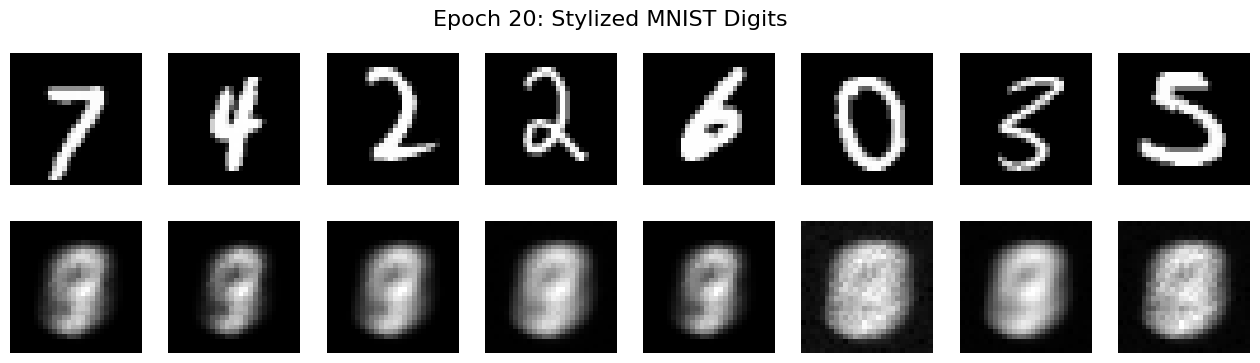

Epoch 21/200 | Entropy Loss: 3.920615
Epoch 22/200 | Entropy Loss: 3.874597
Epoch 23/200 | Entropy Loss: 3.847914
Epoch 24/200 | Entropy Loss: 3.839727
Epoch 25/200 | Entropy Loss: 3.839284
Epoch 26/200 | Entropy Loss: 3.781989
Epoch 27/200 | Entropy Loss: 3.771279
Epoch 28/200 | Entropy Loss: 3.746127
Epoch 29/200 | Entropy Loss: 3.709853
Epoch 30/200 | Entropy Loss: 3.690777


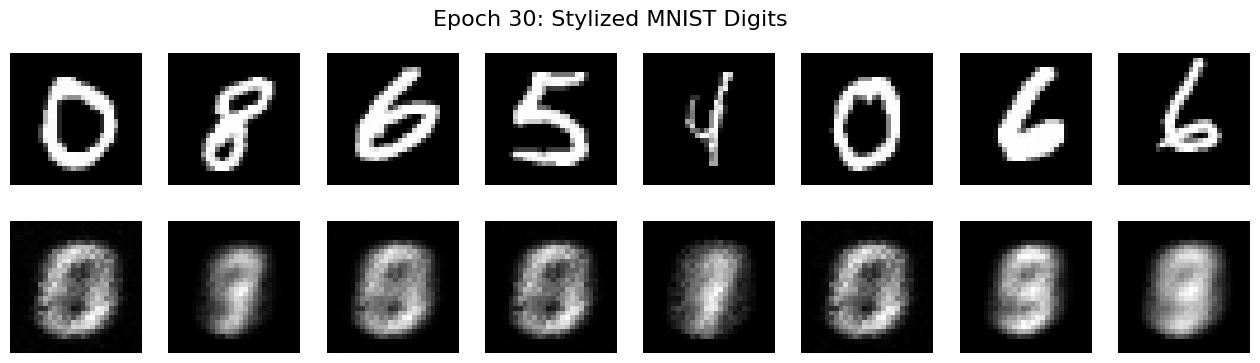

Epoch 31/200 | Entropy Loss: 3.672853
Epoch 32/200 | Entropy Loss: 3.670398
Epoch 33/200 | Entropy Loss: 3.619510
Epoch 34/200 | Entropy Loss: 3.624483
Epoch 35/200 | Entropy Loss: 3.615580
Epoch 36/200 | Entropy Loss: 3.612553
Epoch 37/200 | Entropy Loss: 3.596228
Epoch 38/200 | Entropy Loss: 3.573119
Epoch 39/200 | Entropy Loss: 3.575002
Epoch 40/200 | Entropy Loss: 3.545464


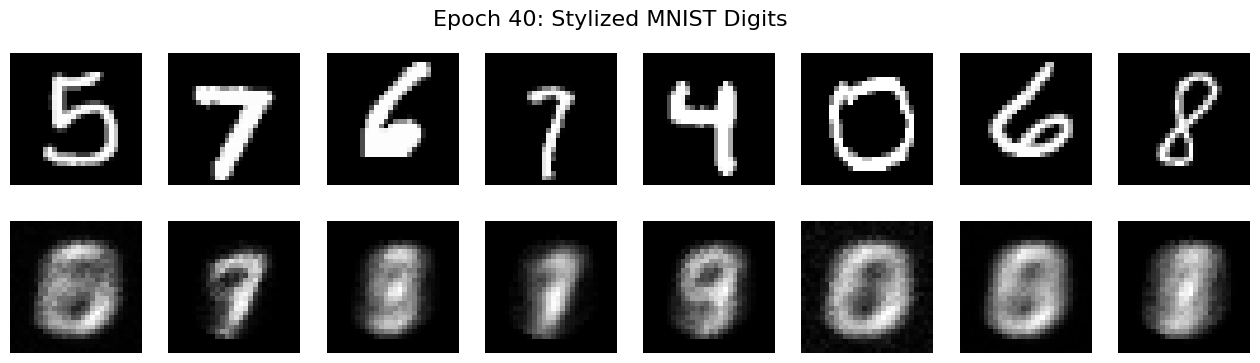

Epoch 41/200 | Entropy Loss: 3.573245
Epoch 42/200 | Entropy Loss: 3.551650
Epoch 43/200 | Entropy Loss: 3.548815
Epoch 44/200 | Entropy Loss: 3.540164
Epoch 45/200 | Entropy Loss: 3.535238
Epoch 46/200 | Entropy Loss: 3.513790
Epoch 47/200 | Entropy Loss: 3.512176
Epoch 48/200 | Entropy Loss: 3.518189
Epoch 49/200 | Entropy Loss: 3.540988
Epoch 50/200 | Entropy Loss: 3.519920


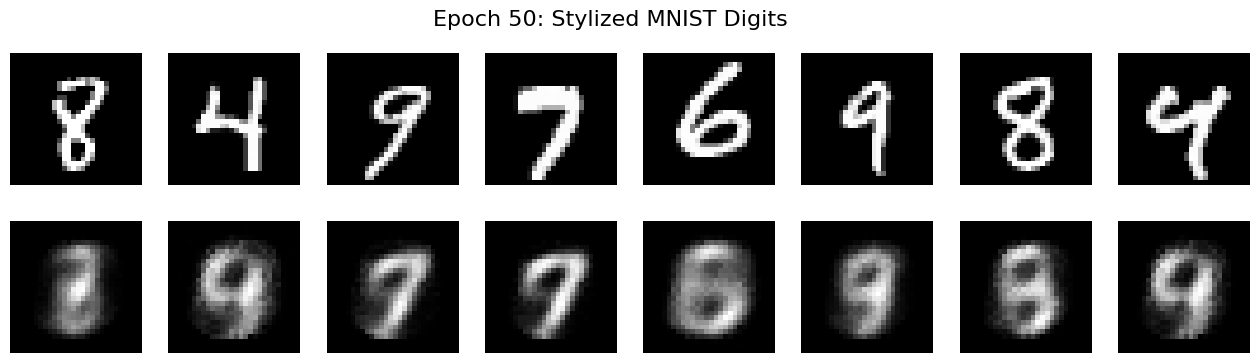

Epoch 51/200 | Entropy Loss: 3.515058
Epoch 52/200 | Entropy Loss: 3.513271
Epoch 53/200 | Entropy Loss: 3.519655
Epoch 54/200 | Entropy Loss: 3.519797
Epoch 55/200 | Entropy Loss: 3.532192
Epoch 56/200 | Entropy Loss: 3.515764
Epoch 57/200 | Entropy Loss: 3.493307
Epoch 58/200 | Entropy Loss: 3.526262
Epoch 59/200 | Entropy Loss: 3.497991
Epoch 60/200 | Entropy Loss: 3.494879


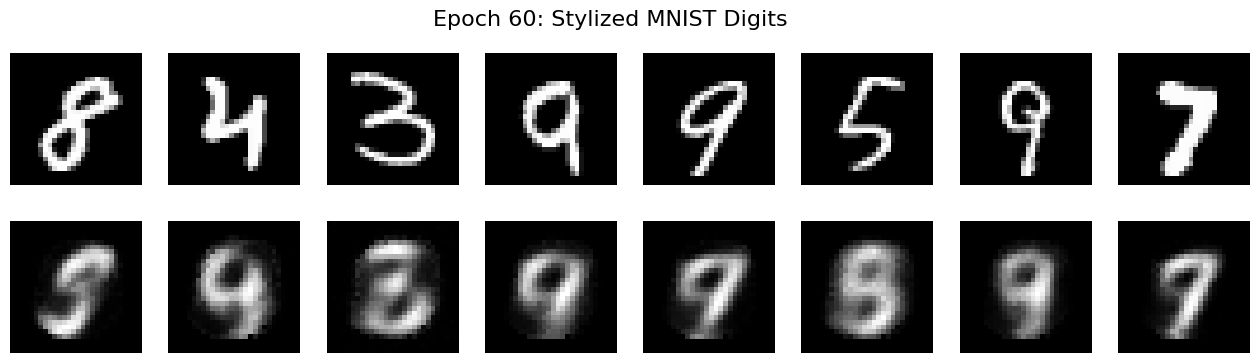

Epoch 61/200 | Entropy Loss: 3.498866
Epoch 62/200 | Entropy Loss: 3.467457
Epoch 63/200 | Entropy Loss: 3.497815
Epoch 64/200 | Entropy Loss: 3.464725
Epoch 65/200 | Entropy Loss: 3.493151
Epoch 66/200 | Entropy Loss: 3.491355
Epoch 67/200 | Entropy Loss: 3.473705
Epoch 68/200 | Entropy Loss: 3.446984
Epoch 69/200 | Entropy Loss: 3.466825
Epoch 70/200 | Entropy Loss: 3.449836


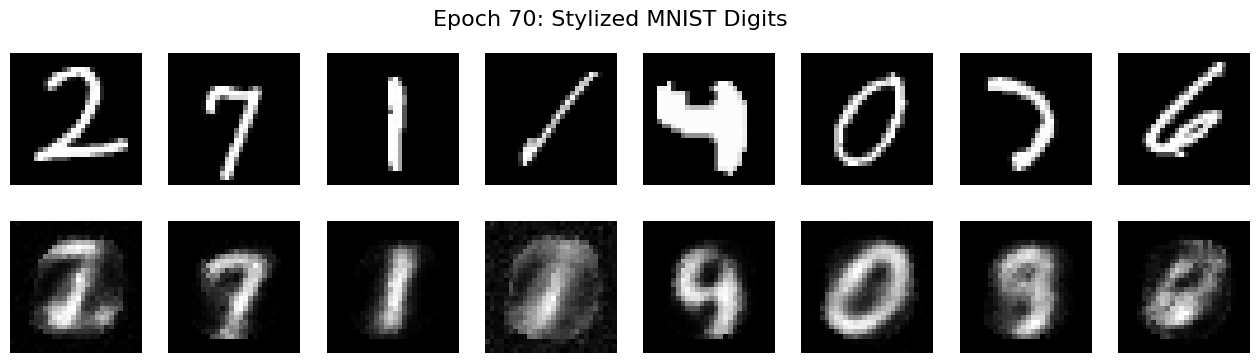

Epoch 71/200 | Entropy Loss: 3.478884
Epoch 72/200 | Entropy Loss: 3.473205
Epoch 73/200 | Entropy Loss: 3.452111
Epoch 74/200 | Entropy Loss: 3.444877
Epoch 75/200 | Entropy Loss: 3.462999
Epoch 76/200 | Entropy Loss: 3.465327
Epoch 77/200 | Entropy Loss: 3.433284
Epoch 78/200 | Entropy Loss: 3.432026
Epoch 79/200 | Entropy Loss: 3.452719
Epoch 80/200 | Entropy Loss: 3.452473


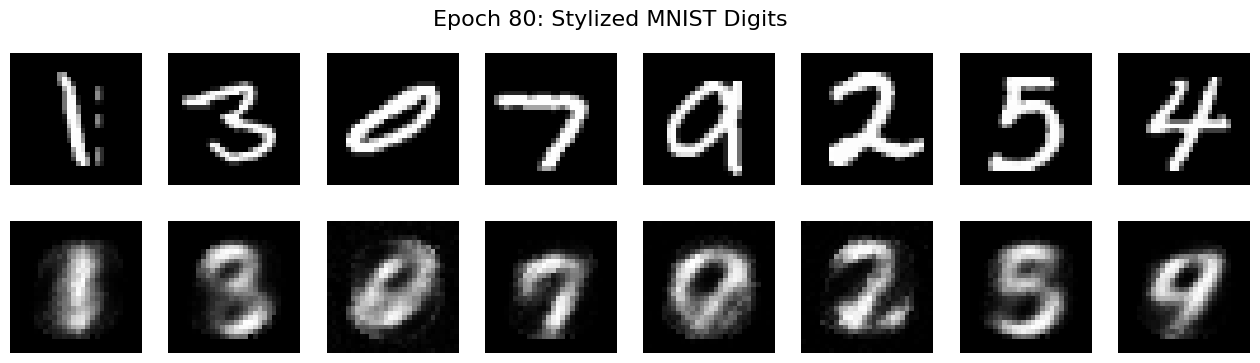

Epoch 81/200 | Entropy Loss: 3.486370
Epoch 82/200 | Entropy Loss: 3.467910
Epoch 83/200 | Entropy Loss: 3.455694
Epoch 84/200 | Entropy Loss: 3.477415
Epoch 85/200 | Entropy Loss: 3.480486
Epoch 86/200 | Entropy Loss: 3.487353
Epoch 87/200 | Entropy Loss: 3.478951
Epoch 88/200 | Entropy Loss: 3.509212
Epoch 89/200 | Entropy Loss: 3.491379
Epoch 90/200 | Entropy Loss: 3.497398


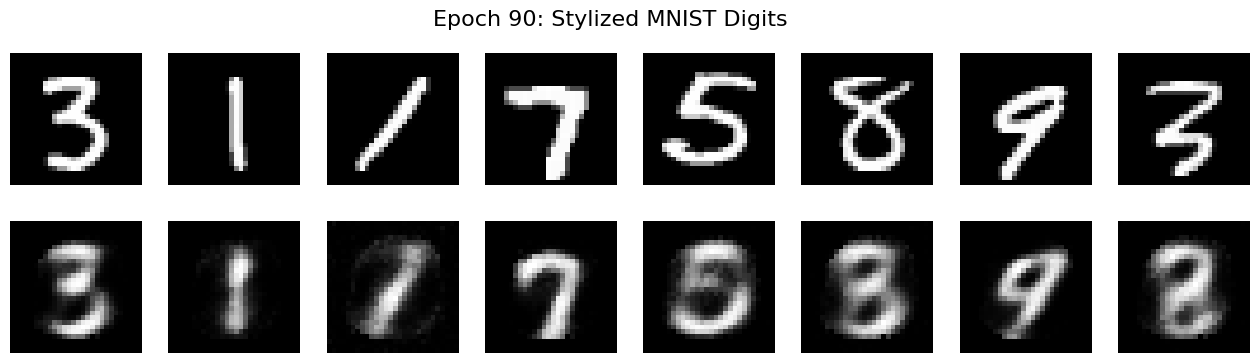

Epoch 91/200 | Entropy Loss: 3.502533
Epoch 92/200 | Entropy Loss: 3.507869
Epoch 93/200 | Entropy Loss: 3.525662
Epoch 94/200 | Entropy Loss: 3.517076
Epoch 95/200 | Entropy Loss: 3.518464
Epoch 96/200 | Entropy Loss: 3.520408
Epoch 97/200 | Entropy Loss: 3.526761
Epoch 98/200 | Entropy Loss: 3.506703
Epoch 99/200 | Entropy Loss: 3.498558
Epoch 100/200 | Entropy Loss: 3.506466


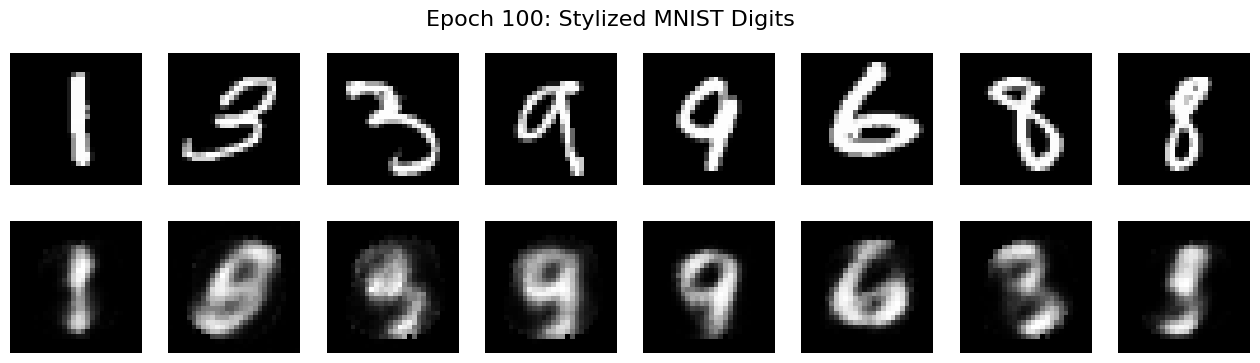

Epoch 101/200 | Entropy Loss: 3.515563
Epoch 102/200 | Entropy Loss: 3.488853
Epoch 103/200 | Entropy Loss: 3.482117
Epoch 104/200 | Entropy Loss: 3.483716
Epoch 105/200 | Entropy Loss: 3.475608
Epoch 106/200 | Entropy Loss: 3.469445
Epoch 107/200 | Entropy Loss: 3.468611
Epoch 108/200 | Entropy Loss: 3.451421
Epoch 109/200 | Entropy Loss: 3.447764
Epoch 110/200 | Entropy Loss: 3.435679


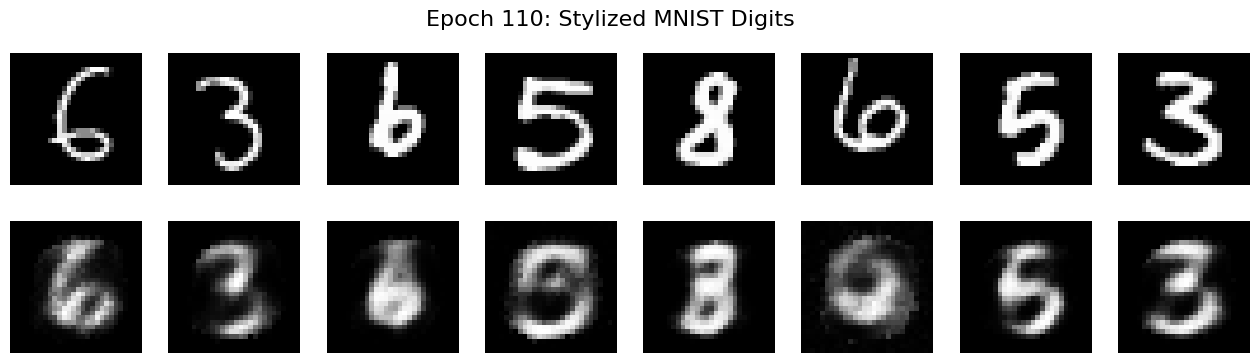

Epoch 111/200 | Entropy Loss: 3.441248
Epoch 112/200 | Entropy Loss: 3.423031
Epoch 113/200 | Entropy Loss: 3.415608
Epoch 114/200 | Entropy Loss: 3.400502
Epoch 115/200 | Entropy Loss: 3.399020
Epoch 116/200 | Entropy Loss: 3.389007
Epoch 117/200 | Entropy Loss: 3.381410
Epoch 118/200 | Entropy Loss: 3.372134
Epoch 119/200 | Entropy Loss: 3.357265
Epoch 120/200 | Entropy Loss: 3.362725


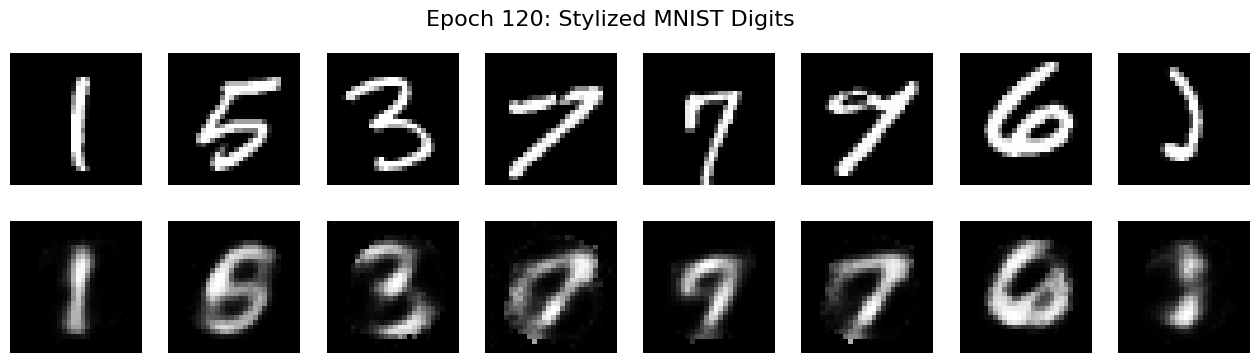

Epoch 121/200 | Entropy Loss: 3.353145
Epoch 122/200 | Entropy Loss: 3.337768
Epoch 123/200 | Entropy Loss: 3.332403
Epoch 124/200 | Entropy Loss: 3.324641
Epoch 125/200 | Entropy Loss: 3.325995
Epoch 126/200 | Entropy Loss: 3.335102
Epoch 127/200 | Entropy Loss: 3.315449
Epoch 128/200 | Entropy Loss: 3.302840
Epoch 129/200 | Entropy Loss: 3.293520
Epoch 130/200 | Entropy Loss: 3.297445


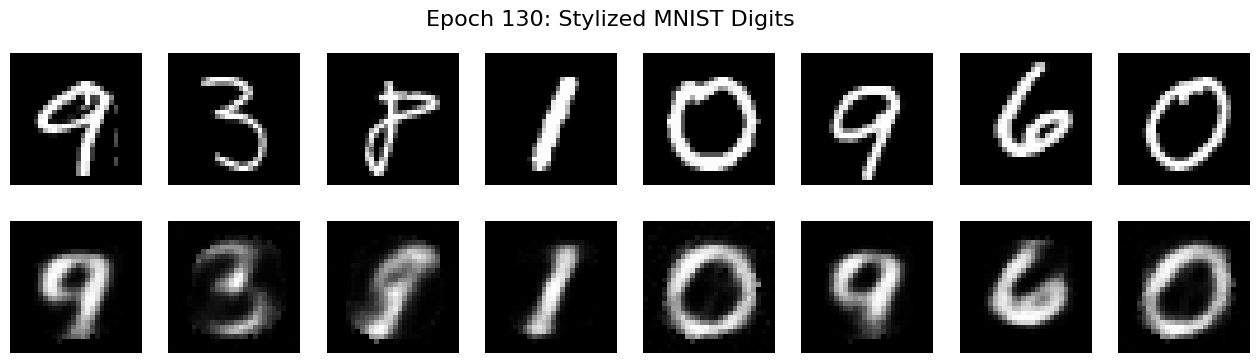

Epoch 131/200 | Entropy Loss: 3.289582
Epoch 132/200 | Entropy Loss: 3.283206
Epoch 133/200 | Entropy Loss: 3.290936
Epoch 134/200 | Entropy Loss: 3.272291
Epoch 135/200 | Entropy Loss: 3.271219
Epoch 136/200 | Entropy Loss: 3.266243
Epoch 137/200 | Entropy Loss: 3.270135
Epoch 138/200 | Entropy Loss: 3.259271
Epoch 139/200 | Entropy Loss: 3.264001
Epoch 140/200 | Entropy Loss: 3.257243


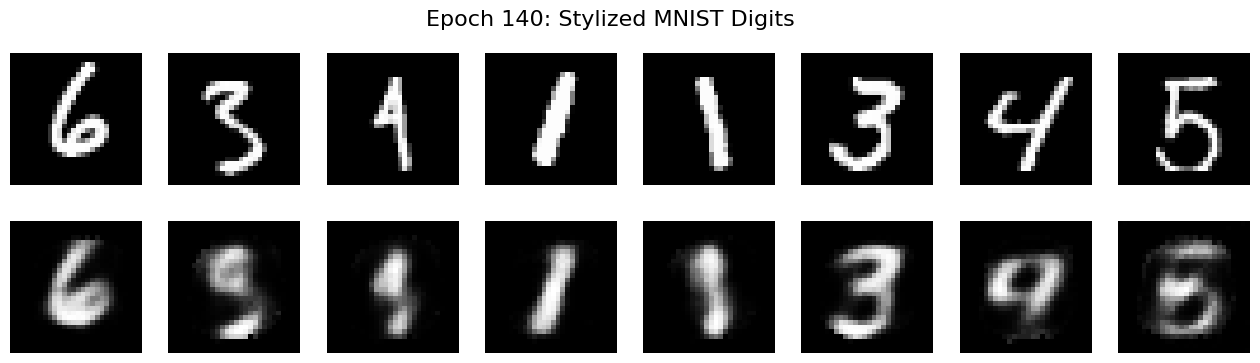

Epoch 141/200 | Entropy Loss: 3.249471
Epoch 142/200 | Entropy Loss: 3.245359
Epoch 143/200 | Entropy Loss: 3.259686
Epoch 144/200 | Entropy Loss: 3.237893
Epoch 145/200 | Entropy Loss: 3.247677
Epoch 146/200 | Entropy Loss: 3.255635
Epoch 147/200 | Entropy Loss: 3.232573
Epoch 148/200 | Entropy Loss: 3.230160
Epoch 149/200 | Entropy Loss: 3.224792
Epoch 150/200 | Entropy Loss: 3.229194


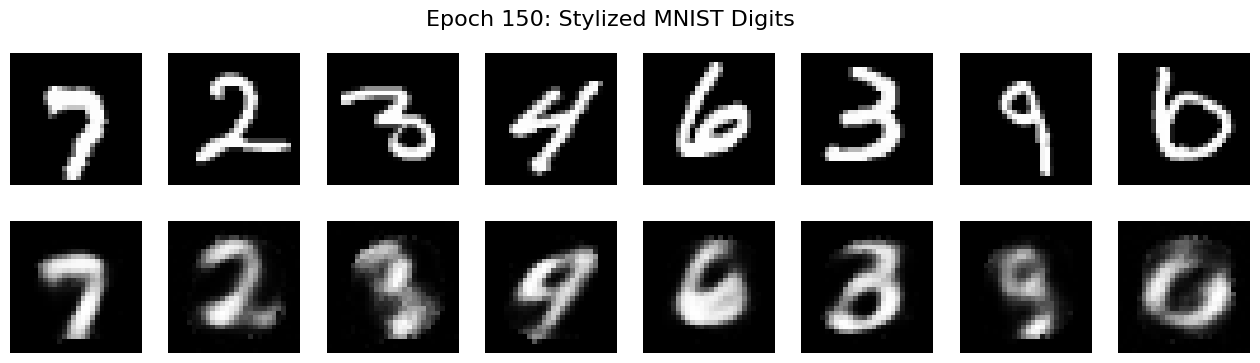

Epoch 151/200 | Entropy Loss: 3.229750
Epoch 152/200 | Entropy Loss: 3.236282
Epoch 153/200 | Entropy Loss: 3.210825
Epoch 154/200 | Entropy Loss: 3.206605
Epoch 155/200 | Entropy Loss: 3.212082
Epoch 156/200 | Entropy Loss: 3.203904
Epoch 157/200 | Entropy Loss: 3.199860
Epoch 158/200 | Entropy Loss: 3.195156
Epoch 159/200 | Entropy Loss: 3.185163
Epoch 160/200 | Entropy Loss: 3.193670


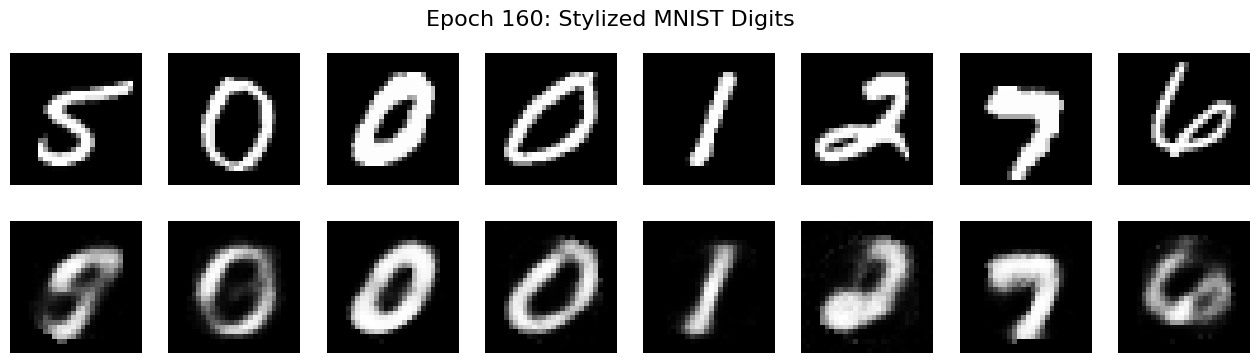

Epoch 161/200 | Entropy Loss: 3.185206
Epoch 162/200 | Entropy Loss: 3.163874
Epoch 163/200 | Entropy Loss: 3.162603
Epoch 164/200 | Entropy Loss: 3.146824
Epoch 165/200 | Entropy Loss: 3.160870
Epoch 166/200 | Entropy Loss: 3.137294
Epoch 167/200 | Entropy Loss: 3.161613
Epoch 168/200 | Entropy Loss: 3.131630
Epoch 169/200 | Entropy Loss: 3.113293
Epoch 170/200 | Entropy Loss: 3.108804


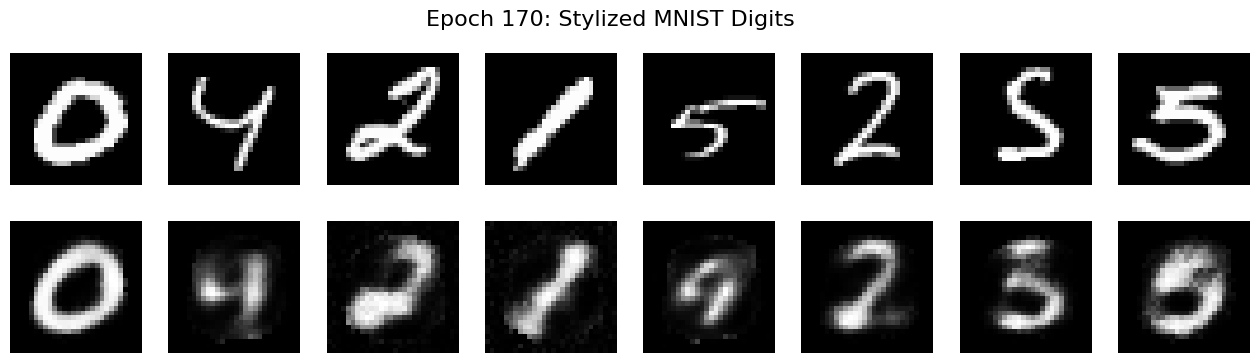

Epoch 171/200 | Entropy Loss: 3.112551
Epoch 172/200 | Entropy Loss: 3.085355
Epoch 173/200 | Entropy Loss: 3.097298
Epoch 174/200 | Entropy Loss: 3.084552
Epoch 175/200 | Entropy Loss: 3.060115
Epoch 176/200 | Entropy Loss: 3.053296
Epoch 177/200 | Entropy Loss: 3.045953
Epoch 178/200 | Entropy Loss: 3.046292
Epoch 179/200 | Entropy Loss: 3.015166
Epoch 180/200 | Entropy Loss: 3.011086


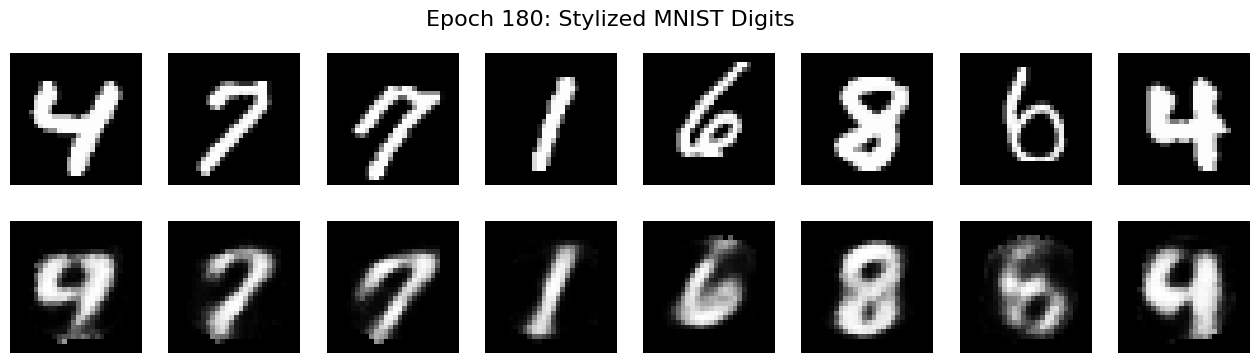

Epoch 181/200 | Entropy Loss: 3.002033
Epoch 182/200 | Entropy Loss: 2.998870
Epoch 183/200 | Entropy Loss: 2.983572
Epoch 184/200 | Entropy Loss: 2.958386
Epoch 185/200 | Entropy Loss: 2.963555
Epoch 186/200 | Entropy Loss: 2.949683
Epoch 187/200 | Entropy Loss: 2.928285
Epoch 188/200 | Entropy Loss: 2.908734
Epoch 189/200 | Entropy Loss: 2.909934
Epoch 190/200 | Entropy Loss: 2.886112


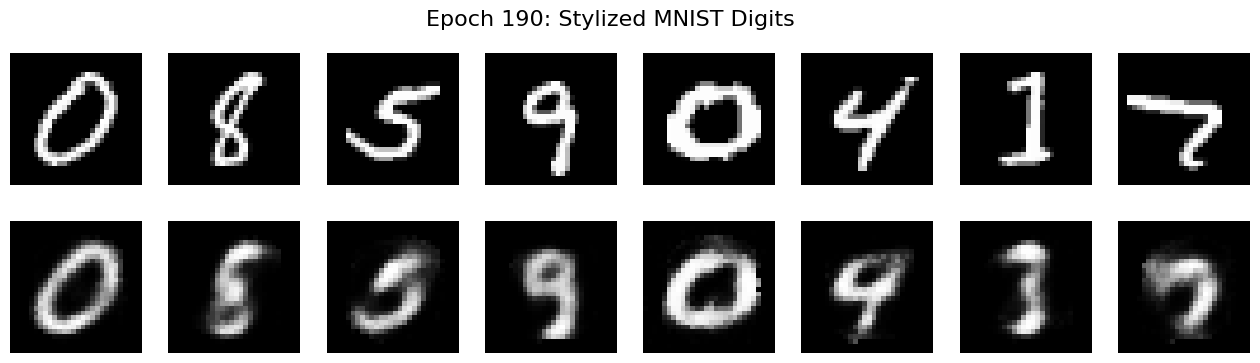

Epoch 191/200 | Entropy Loss: 2.892253
Epoch 192/200 | Entropy Loss: 2.870518
Epoch 193/200 | Entropy Loss: 2.853617
Epoch 194/200 | Entropy Loss: 2.846125
Epoch 195/200 | Entropy Loss: 2.838635
Epoch 196/200 | Entropy Loss: 2.827629
Epoch 197/200 | Entropy Loss: 2.813309
Epoch 198/200 | Entropy Loss: 2.790797
Epoch 199/200 | Entropy Loss: 2.782508
Epoch 200/200 | Entropy Loss: 2.776088


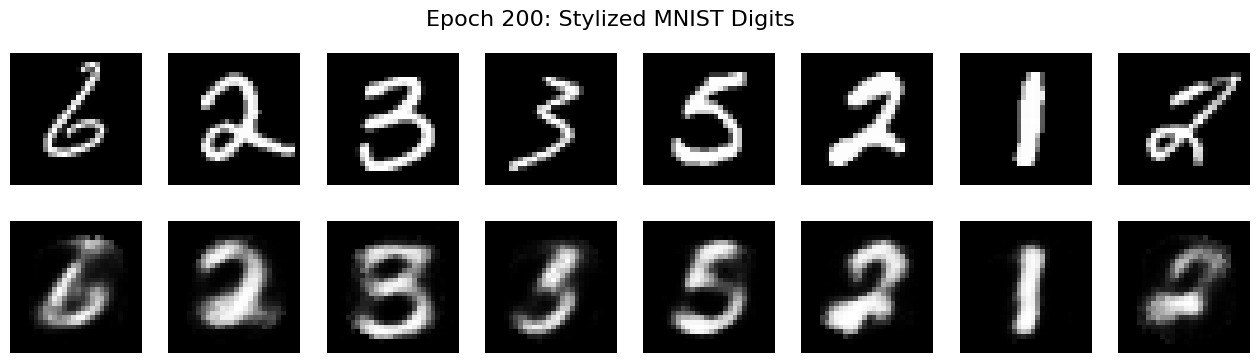

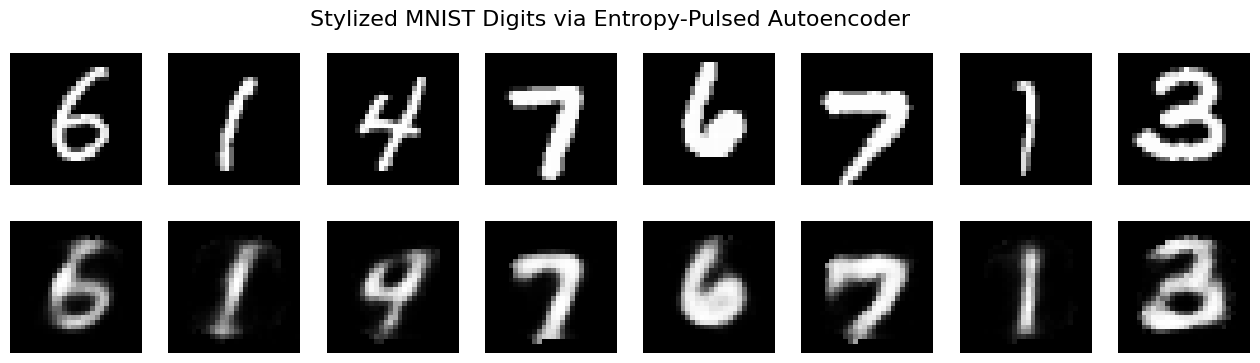

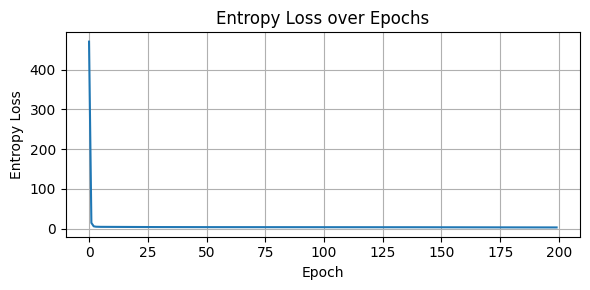

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# --- Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")
print("Running on device:", device)

# --- Hyperparameters
latent_dim = 16
batch_size = 128
epochs = 200
lr = 1e-3
alpha_creative = 100     # entropy exploration multiplier
alpha_rigor = 10     # entropy fit multiplier
beta = 0.000001    # reconstruction anchor
save_outputs_every = 10  # Change this to any value you like


# --- Load MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# --- Entropy loss over latent activations
def entropy_loss(z, bins=30):
    z_np = z.detach().cpu().numpy().flatten()
    hist, _ = np.histogram(z_np, bins=bins, density=True)
    p = hist[hist > 0]
    S = -np.sum(p * np.log(p))
    return 0.5 * np.float32(S)**2

# --- Define Entropy-Aware Autoencoder
class Stylizer(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return z, out

# --- Train model with entropy-pulsed stylization
model = Stylizer(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_history = []

for epoch in range(epochs):
    model.train()
    flip = -alpha_creative if (epoch // 4) % 2 == 0 else alpha_rigor  # alternate max vs min

    epoch_entropy = 0.0

    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()

        z, x_recon = model(x)
        entropy_val = entropy_loss(z)
        recon_loss = nn.MSELoss()(x_recon, x)

        loss = flip * torch.tensor(entropy_val, dtype=torch.float32, requires_grad=True, device=device) + beta * recon_loss
        loss.backward()
        optimizer.step()

        epoch_entropy += entropy_val

    avg_entropy = epoch_entropy / len(train_loader)
    loss_history.append(avg_entropy)
    print(f"Epoch {epoch+1}/{epochs} | Entropy Loss: {avg_entropy:.6f}")
    
    # Save stylized output every N epochs
    if (epoch + 1) % save_outputs_every == 0 or epoch == 0:
        model.eval()
        sample_batch, _ = next(iter(train_loader))
        sample_batch = sample_batch[:8].to(device)

        with torch.no_grad():
            z, recon = model(sample_batch)

        sample_batch = sample_batch.cpu()
        recon = recon.cpu()

        fig, axs = plt.subplots(2, 8, figsize=(16, 4))
        for i in range(8):
            axs[0, i].imshow(sample_batch[i][0], cmap='gray')
            axs[0, i].axis('off')
            axs[1, i].imshow(recon[i][0], cmap='gray')
            axs[1, i].axis('off')
        axs[0, 0].set_ylabel("Original", fontsize=14)
        axs[1, 0].set_ylabel("Stylized", fontsize=14)
        plt.suptitle(f"Epoch {epoch+1}: Stylized MNIST Digits", fontsize=16)
        plt.show()


# --- Visualize stylized outputs
model.eval()
sample_batch, _ = next(iter(train_loader))
sample_batch = sample_batch[:8].to(device)

with torch.no_grad():
    z, recon = model(sample_batch)

sample_batch = sample_batch.cpu()
recon = recon.cpu()

fig, axs = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axs[0, i].imshow(sample_batch[i][0], cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(recon[i][0], cmap='gray')
    axs[1, i].axis('off')
axs[0, 0].set_ylabel("Original", fontsize=14)
axs[1, 0].set_ylabel("Stylized", fontsize=14)
plt.suptitle("Stylized MNIST Digits via Entropy-Pulsed Autoencoder", fontsize=16)
plt.show()

# --- Plot entropy loss over time
plt.figure(figsize=(6, 3))
plt.plot(loss_history)
plt.title("Entropy Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Entropy Loss")
plt.grid(True)
plt.tight_layout()
plt.show()
